# FFT-DI simulator

The content of this notebook looks to implement a direct integration of the Rayleigh-Sommerfeld integral using FFT technique as presented in the manuscript "Fast-Fourier-transform based numerical integration method for the Rayleigh–Sommerfeld diffraction formula" by Shen F. and Wang A. This simulator will be implemented using the pyTorch API enabling the later on possibility to extend this into a digital twin of the optical D2NN configurations allowing to explore these frameworks of optical computing. Nevertheless, the basic transformations of light (e.g. propagation, modulation) are kept in separate classes which can be used piece by piece to construct alternative trainable optical configurations.

In short, the free-space propagation of light is given as the convolution between the initial electric field $E\left(x,y\right)$ and the point-spread function,
\begin{equation}
    g\left(x,y,z\right) = \frac{1}{2\pi} \frac{exp\left(i k t\right)}{r} \frac{z}{r} \left( \frac{1}{r} - ik\right).
\end{equation}
By solving this convolution in the Fourier space of the individual functions the result of the propagation a $z$ distance away from the start is given by
\begin{equation}
    E\left(x, y, z\right) = IFFT2\left[ FFT2\left[ E\left(x,y,0\right)\right] FFT2\left[g\left(x,y,z\right)\right]\right]
\end{equation}

In this notebook we develop a series of functions simulating the propagation of light from the input to the desired output at an arbitrary point $z$>0. As a test, and following the guidance of the aforementioned article we are going to compare the results with the case of uniform light incident on slit where the analytical solutions is given by
\begin{equation}
    E\left(0,0,z\right) = E_0 z \left[ \frac{exp\left(i j k\right)}{z} - \frac{exp\left(i k \sqrt{z^2 + a^2}\right)}{\sqrt{z^2 + a^2}}\right],
\end{equation}
where $a$ is the radius of the circular aperture.

In [1]:
import torch
torch.set_default_dtype(torch.float64)
torch.device("cuda")

import sys
sys.path.append("../")
import Diffraction

import numpy as np

from matplotlib.pyplot import *
%matplotlib widget

# Set Parameters

In [2]:
wavelength = .5 ## micrometers

a = 10 * wavelength  ## radius of the circular aperture

delta_s = .1 * wavelength  ## sampling interval

pixel_radius = int(a/delta_s)

input_shape = (4*int(128), 4*int(128))  ## input window size

computation_window_shape = (2*input_shape[0], 2*input_shape[1])

# Create Input Beam Profile

g:\anaconda3\envs\OC_digital\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Text(0.5, 1.0, '2D FFT of the input aperture mask')

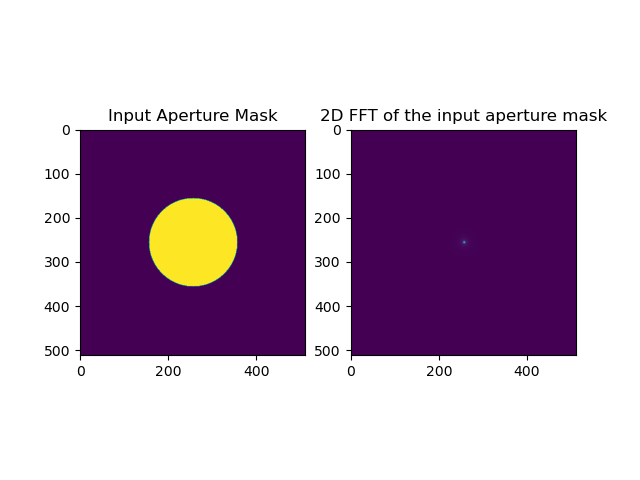

In [3]:
n = 1
aperture_mask = torch.zeros((n, *input_shape), dtype=torch.uint8)

def ApertureMask(window, r, ds):
    w, h = window.shape

    pixel_radius = int(r/ds)  ## number of pixels result in radius a being represented with sampling ds
    
    xx, yy = torch.arange(0,w,1), torch.arange(0,h,1)
    
    xx, yy = torch.meshgrid(xx, yy)
    
    xx, yy = xx-int(w/2), yy-int(h/2)

    window[torch.where(torch.sqrt(xx**2 + yy**2) <= pixel_radius)] = 1.
                
    return window

aperture_mask[0] = ApertureMask(aperture_mask[0], a, delta_s)  ## Input Aperture Mask

fft_aperture_mask = torch.fft.fft2(aperture_mask)
fft_aperture_mask = torch.fft.fftshift(fft_aperture_mask)

fig, axs = subplots(1,2)
axs[0].imshow(aperture_mask[0])
axs[0].set_title("Input Aperture Mask")

axs[1].imshow(np.abs(fft_aperture_mask[0]))
axs[1].set_title("2D FFT of the input aperture mask")

In [4]:
propagation_distance = 100 * wavelength

# Model

In [5]:
from torch.nn import *

class PropagationTwin(Module):
    def __init__(self, z, wavelength, ds, input_shape, output_shape):
        super(PropagationTwin, self).__init__()

        w_pad = int((output_shape[0]-input_shape[0])/2)
        h_pad = int((output_shape[1]-input_shape[1])/2)

        self.padding = ZeroPad2d((w_pad, w_pad, h_pad, h_pad))

        self.propagation_1 = Diffraction.RSDiffraction(z, 2*np.pi/wavelength, wavelength, ds, output_shape, self.padding)

        self.measurement = Diffraction.IntensityMeasurement()

    def SimulateSystem(self, input):
        input = self.padding(input)
        
        input = self.propagation_1.Propagate(input)
        
        output_intensity = self.measurement.Measure(input)

        return output_intensity
    
optical_system = PropagationTwin(propagation_distance, wavelength, delta_s, input_shape, computation_window_shape)

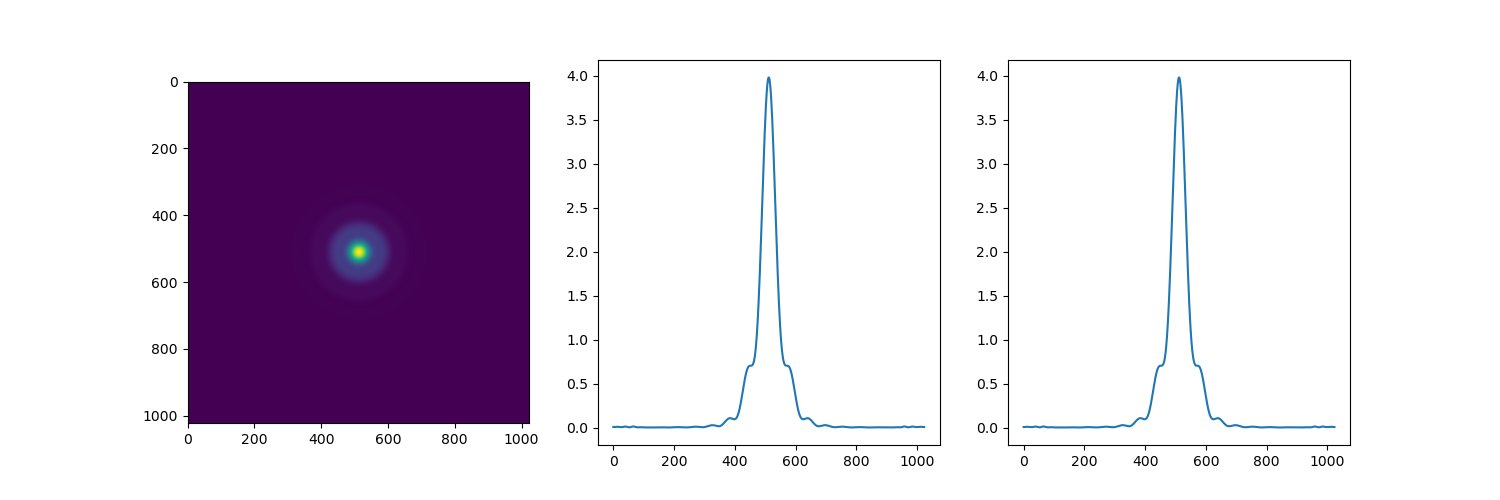

In [6]:
intensity = optical_system.SimulateSystem(aperture_mask)

fig, axs = subplots(1, 3, figsize=(15,5))
axs[0].imshow(intensity[0])

axs[1].plot(intensity[0,:,int(intensity.shape[2]/2)])

axs[2].plot(intensity[0,int(intensity.shape[1]/2)])

# Central Point Intensity With Distance

In [7]:
def ExactSolutionCircularAperture(z,k,a):
    real = torch.tensor([0], dtype=torch.float64)
    imag = torch.tensor([1], dtype=torch.float64)
    j = torch.complex(real, imag)
    return 1. * z * (np.exp(j*k*z)/z - np.exp(j*k*np.sqrt(z**2 + a**2))/(np.sqrt(z**2 + a**2)))

In [8]:
distances = np.linspace(.1,25.,50)

I_0 = np.zeros(len(distances))
I_exact = np.zeros(len(distances))
for _d in range(len(distances)):
    optical_system = PropagationTwin(distances[_d], wavelength, delta_s, input_shape, computation_window_shape)
    intensity = optical_system.SimulateSystem(aperture_mask)
    I_0[_d] = intensity[0, int(intensity.shape[1]/2), int(intensity.shape[2]/2)]
    
    expected_E = ExactSolutionCircularAperture(distances[_d], 2*np.pi/wavelength, a)
    I_exact[_d] = torch.abs(expected_E)**2

Text(0, 0.5, '$I\\left(z\\right)/I_0$')

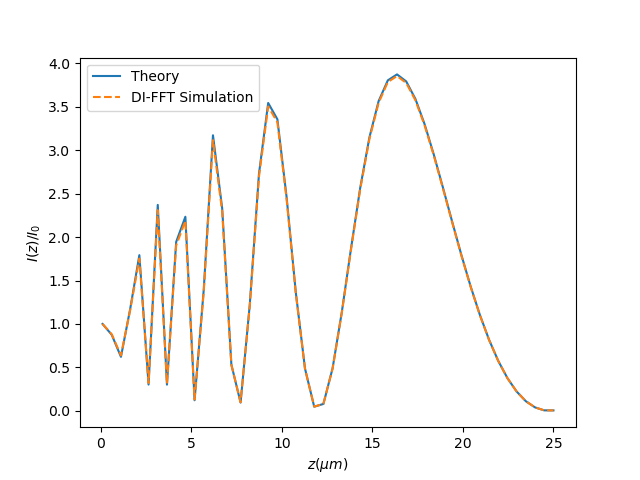

In [9]:
fig, axs = subplots(1)
axs.plot(distances, (I_exact)/(I_exact[0]), label="Theory")
axs.plot(distances, (I_0)/(I_0[0]), "--", label="DI-FFT Simulation")

axs.legend()

axs.set_xlabel(r"$z\left(\mu m\right)$")

axs.set_ylabel(r"$I\left(z\right)/I_0$")